# Exercise 2

In [1]:
# Import modules
import pandas as pd
import shap
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

In [2]:
# Provide data filenames
RAW_ADULT_DATA = "data/adult.csv"

## Data Preprocessing
Here, we load and preprocess the data, and split it into a training and test set.

In [3]:
df = pd.read_csv(RAW_ADULT_DATA)  # Load data to dataframe


print(f"No. of rows: {df.shape[0]}")
print(f"No. of columns: {df.shape[1]}")
df.head()


No. of rows: 32561
No. of columns: 15


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,NaN,Widowed,NaN,Not-in-family,White,Female,NaN,4356.0,40.0,United-States,<=50K
1,82,Private,132870,HS-grad,NaN,Widowed,Exec-managerial,Not-in-family,White,Female,NaN,4356.0,18.0,United-States,<=50K
2,66,NaN,186061,Some-college,10.0,Widowed,NaN,Unmarried,Black,Female,NaN,4356.0,40.0,United-States,<=50K
3,54,Private,140359,7th-8th,NaN,Divorced,Machine-op-inspct,Unmarried,White,Female,NaN,3900.0,40.0,United-States,<=50K
4,41,Private,264663,Some-college,10.0,Separated,Prof-specialty,Own-child,White,Female,NaN,3900.0,40.0,United-States,<=50K


We drop any rows containing missing data points. It was also mentioned in class that there are a number of rows in which the value of capital.gain is 99999, which is likely used to represent "NaN", so we drop these rows as well.

In [4]:
df = df[df["capital.gain"] != 99999.0]  # Remove rows where capital.gain = 99999.0
df["capital.gain"] = df["capital.gain"].fillna(0)  # Replace NaN values in capital.gain with 0
df["capital.loss"] = df["capital.loss"].fillna(0)  # Replace NaN values in capital.loss with 0

df = df.dropna().rename(columns={"income": "income.exceeds_50k" })   # Remove rows with missing values and rename column income
df["income.exceeds_50k"] = df["income.exceeds_50k"].map({
    "<=50K": 0,
    ">50K": 1,
})  # Replace values in income column
print(df["income.exceeds_50k"].value_counts(), "\n")  # Print value counts of income column

print(f"No. of rows: {df.shape[0]}")
print(f"No. of columns: {df.shape[1]}")
df.head()

income.exceeds_50k
0    10791
1     5519
Name: count, dtype: int64 

No. of rows: 16310
No. of columns: 15


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income.exceeds_50k
4,41,Private,264663,Some-college,10.0,Separated,Prof-specialty,Own-child,White,Female,0.0,3900.0,40.0,United-States,0
7,74,State-gov,88638,Doctorate,16.0,Never-married,Prof-specialty,Other-relative,White,Female,0.0,3683.0,20.0,United-States,1
10,45,Private,172274,Doctorate,16.0,Divorced,Prof-specialty,Unmarried,Black,Female,0.0,3004.0,35.0,United-States,1
11,38,Self-emp-not-inc,164526,Prof-school,15.0,Never-married,Prof-specialty,Not-in-family,White,Male,0.0,2824.0,45.0,United-States,1
12,52,Private,129177,Bachelors,13.0,Widowed,Other-service,Not-in-family,White,Female,0.0,2824.0,20.0,United-States,1


In [5]:
# Specify categorical data and convert to their category codes, since SHAP cannot handle category data type
# https://xgboost.readthedocs.io/en/stable/tutorials/categorical.html#training-with-scikit-learn-interface


for col in df.columns:
    if df[col].dtype != "int64":
        df[col] = df[col].astype("category")

        category_mapping = dict(enumerate(df[col].cat.categories))  # Get mapping of category codes to their values
        print(f"'{col}': {category_mapping}")

        df[col] = df[col].cat.codes

        

df.head()

'workclass': {0: 'Federal-gov', 1: 'Local-gov', 2: 'Private', 3: 'Self-emp-inc', 4: 'Self-emp-not-inc', 5: 'State-gov', 6: 'Without-pay'}
'education': {0: 'Assoc-acdm', 1: 'Assoc-voc', 2: 'Bachelors', 3: 'Doctorate', 4: 'Masters', 5: 'Prof-school', 6: 'Some-college'}
'education.num': {0: 10.0, 1: 11.0, 2: 12.0, 3: 13.0, 4: 14.0, 5: 15.0, 6: 16.0}
'marital.status': {0: 'Divorced', 1: 'Married-AF-spouse', 2: 'Married-civ-spouse', 3: 'Married-spouse-absent', 4: 'Never-married', 5: 'Separated', 6: 'Widowed'}
'occupation': {0: 'Adm-clerical', 1: 'Armed-Forces', 2: 'Craft-repair', 3: 'Exec-managerial', 4: 'Farming-fishing', 5: 'Handlers-cleaners', 6: 'Machine-op-inspct', 7: 'Other-service', 8: 'Priv-house-serv', 9: 'Prof-specialty', 10: 'Protective-serv', 11: 'Sales', 12: 'Tech-support', 13: 'Transport-moving'}
'relationship': {0: 'Husband', 1: 'Not-in-family', 2: 'Other-relative', 3: 'Own-child', 4: 'Unmarried', 5: 'Wife'}
'race': {0: 'Amer-Indian-Eskimo', 1: 'Asian-Pac-Islander', 2: 'Black

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income.exceeds_50k
4,41,2,264663,6,0,5,9,3,4,0,0,75,30,38,0
7,74,5,88638,3,6,4,9,2,4,0,0,74,10,38,1
10,45,2,172274,3,6,0,9,4,2,0,0,73,25,38,1
11,38,4,164526,5,5,4,9,1,4,1,0,72,35,38,1
12,52,2,129177,2,3,6,7,1,4,0,0,72,10,38,1


In [6]:
X = df.drop(columns=["income.exceeds_50k"])
y = df["income.exceeds_50k"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

## Model Fitting


In [7]:
highest_accuracy = 0
best_tree_method = None

# Iterate through all combinations of max_depth and learning_rate to find model with highest accuracy
for tree_method in ["approx", "hist"]:
    bst = XGBClassifier(
        tree_method=tree_method,
        objective="binary:logistic",
        enable_categorical=True, 
        seed=8
    )
    bst.fit(X_train, y_train)
    accuracy = bst.score(X_test, y_test)
    print(f"accuracy: {accuracy:.3f} | tree_method: {tree_method}")

    if accuracy > highest_accuracy:
        highest_accuracy = accuracy
        best_tree_method = tree_method
    
print(f"\nBest accuracy: {highest_accuracy:.3f} (tree method: {best_tree_method})")

accuracy: 0.841 | tree_method: approx
accuracy: 0.840 | tree_method: hist

Best accuracy: 0.841 (tree method: approx)


In [8]:
# Obtain model with best accuracy
bst = XGBClassifier(
        tree_method=best_tree_method,
        objective="binary:logistic",
        enable_categorical=True, 
        seed=8
    )
bst.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## Model Interpretation


### Feature Importance
Here, we plot the feature importance in explaining our model's prediction of whether income exceeds $50k/year.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

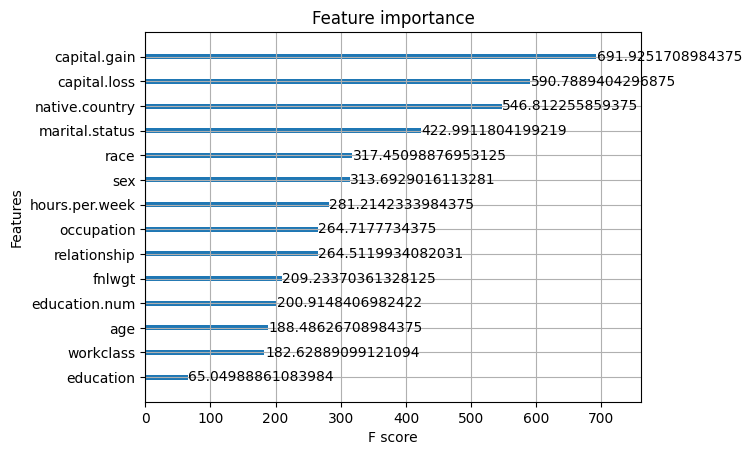

In [9]:
xgb.plot_importance(bst, importance_type="cover")

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

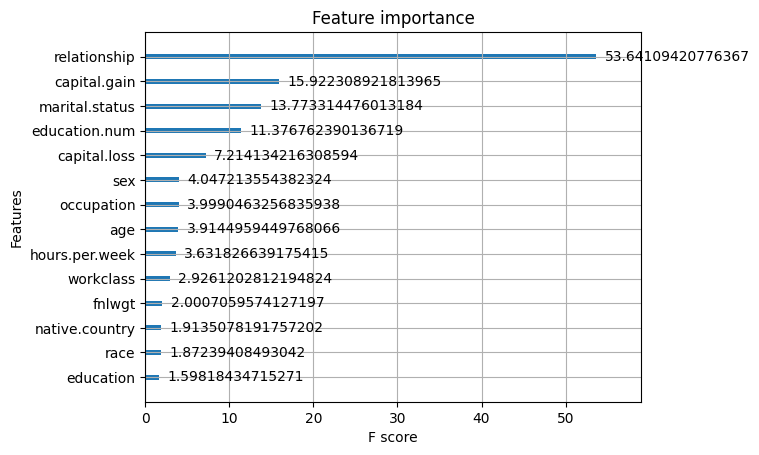

In [10]:
xgb.plot_importance(bst, importance_type="gain")

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

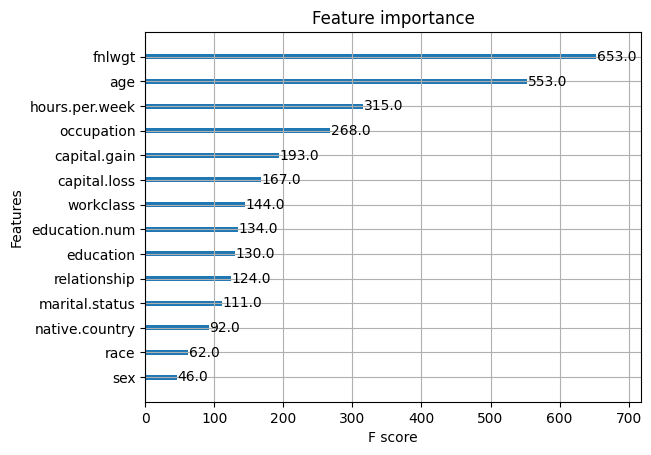

In [11]:
xgb.plot_importance(bst, importance_type="weight")

### SHAP Values

In [12]:
# Compute SHAP values
explainer = shap.Explainer(bst)
shap_values = explainer(X_test)

#### Global Plots

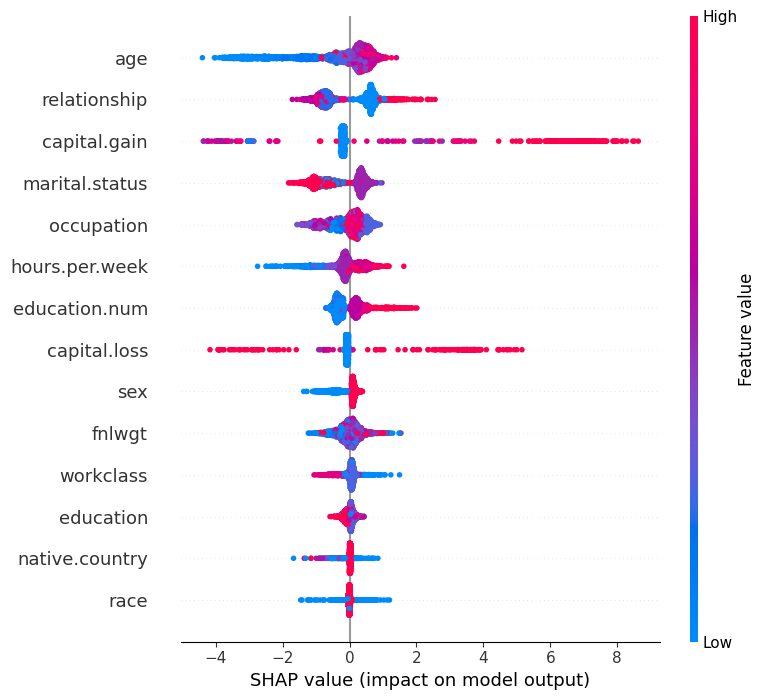

In [13]:
# Obtain summary plot
shap.summary_plot(shap_values, X_test)

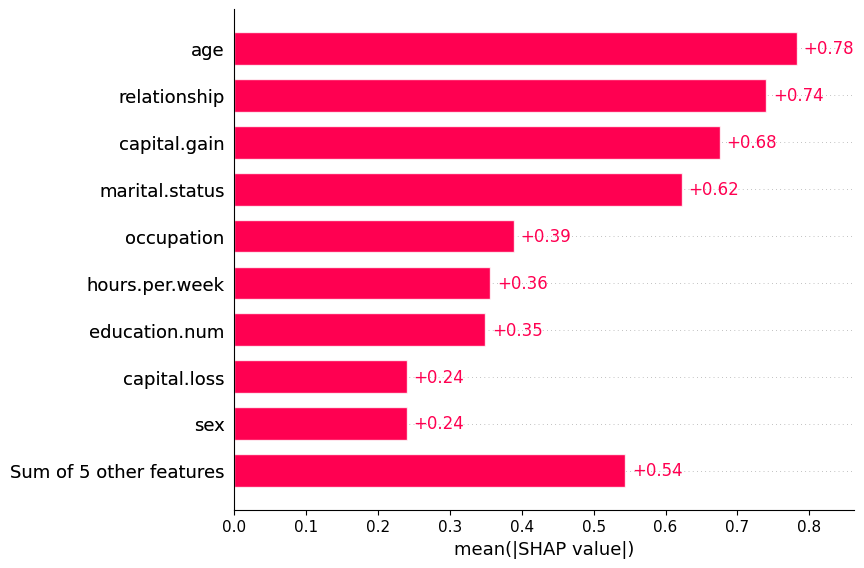

In [14]:
# Obtain global bar plot
shap.plots.bar(shap_values)

In [15]:
# Obtain force plot
shap.initjs()
shap.plots.force(shap_values.sample(100, random_state=8))

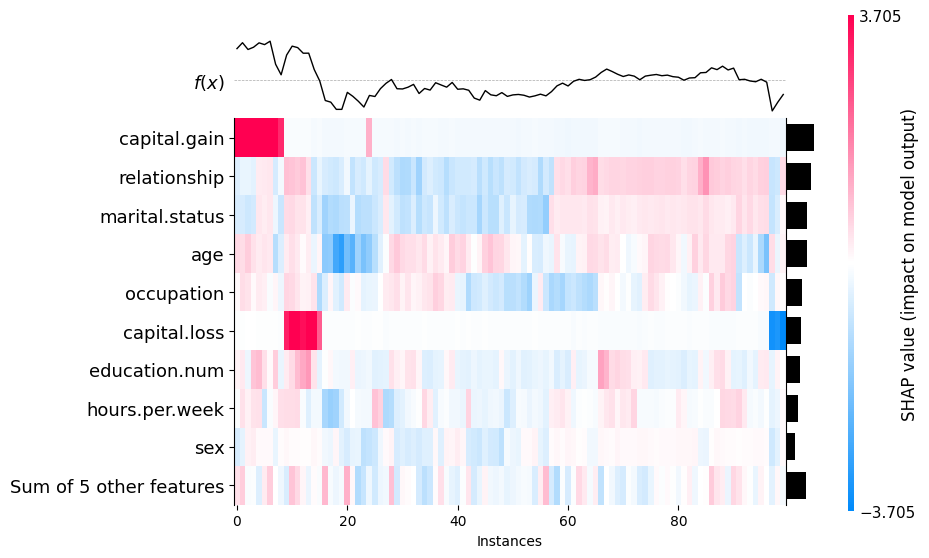

<Axes: xlabel='Instances'>

In [16]:
# # Obtain heatmap
shap.plots.heatmap(shap_values.sample(100, random_state=8))

#### Feature Interaction

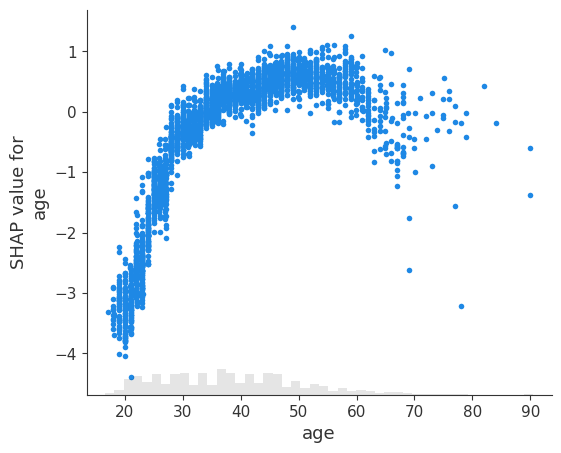

In [17]:
# Obtain dependence plot for age
shap.plots.scatter(shap_values[:, "age"])

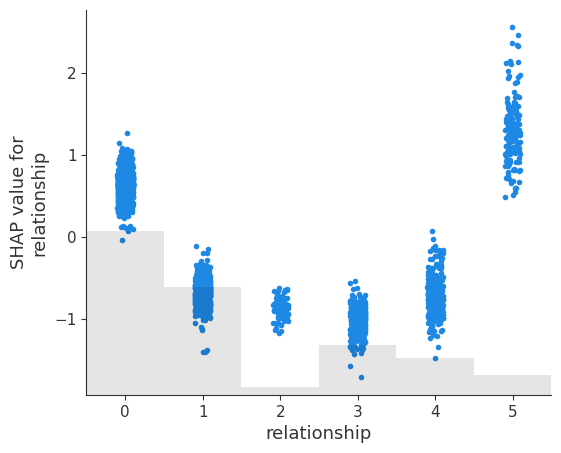

In [18]:
# Obtain dependence plot for relationship
shap.plots.scatter(shap_values[:, shap_values.abs.mean(0).argsort[-2]])

In [19]:
# Randomly select a row based on the instance selection criteria
temp_df = pd.DataFrame(shap_values.data, columns=X_test.columns)
mask = (temp_df["age"] == 30) & (temp_df["education"] == 5) & (temp_df["sex"] == 0)
row_index = temp_df[mask].sample(1, random_state=8).index[0]

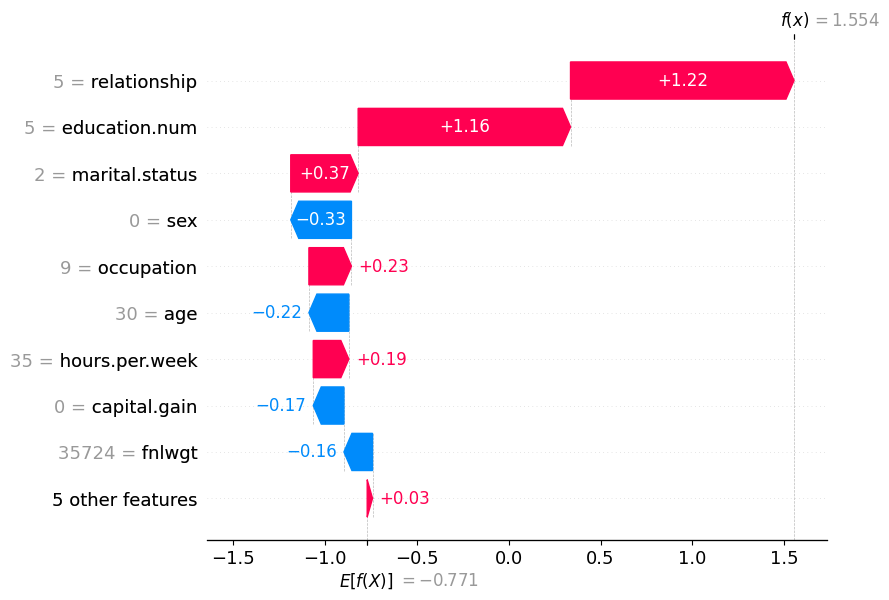

In [20]:
# Obtain a waterfall plot for a single prediction
shap.plots.waterfall(shap_values[row_index])